In [1]:
import pandas as pd
import numpy as np
import csv
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from pandas.plotting import scatter_matrix
from matplotlib import cm
from matplotlib import pyplot as plt
import plotly.express as px
from sklearn.preprocessing import minmax_scale
from numpy import inf
from sklearn.metrics.pairwise import cosine_similarity
import umap
from itertools import product
import networkx as nx
import json
import pyreadr
import ast
import obonet
import joblib
import scipy.stats as stats
import networkx as nx
from sklearn.preprocessing import Normalizer
import seaborn as sns
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from IPython.display import Latex
import torch
import pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score
from collections import defaultdict
import numpy as np
import gzip
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, auc
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_recall_curve
#from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import precision_score
from pyarrow import feather 
from sklearn.metrics import recall_score
import random
%matplotlib inline

In [2]:
#loading data
def filter_row_emb(x):
    if all(v == 0 for v in x):
        return 1
    else:
        return 0
    

def load_parse_ftr(ftr_file, node_name):
    df = pd.read_feather(ftr_file)
    
    column_name_dict = {
        'ID(n)': 'ID',
        'labels(n)': 'labels',
        'n.`fastrp-embedding`': 'fastrp_embedding',
        'n.description': 'description',
        'n.id': 'id',
        'n.name': 'name',
        'n.synonyms': 'synonyms',
        'n.type': 'type'
    }
    
    df = df.rename(columns=column_name_dict)
    
    df['fastrp_embedding'] = df['fastrp_embedding'].values
    df['keep'] = df['fastrp_embedding'].apply(filter_row_emb)
    df = df[df['keep'] == 0]
    df = df.reset_index(drop=True)
    
    data_df = df[['id', 'fastrp_embedding']]
    embedding_column = 'fastrp_embedding_' + node_name
    data_df.columns = [node_name, embedding_column]
    
    return data_df

In [3]:
def mapping_data(mapping_file, node_name1, node_name2):
    df =  pd.read_csv(mapping_file, header=0, sep='\t', quotechar='"', error_bad_lines=False)
    df = df[['Gene', 'Phenotype']]
    df = df.drop_duplicates()
    df = df.reset_index(drop=True)
    df.columns = [node_name1, node_name2]
    df['labels'] = 1
    df['map'] = df[node_name1] + '_' + df[node_name2]
    return df

In [4]:
class GenerateData:
    def __init__(self, phenotype_df, map_df, gene_df, total_links=50000, total_unlink_pairs=25, 
                 total_datapoints=150000, seed=42, batch_size=10000):
        self.phenotype_df = phenotype_df
        self.map_df = map_df
        self.gene_df = gene_df
        self.total_links = total_links
        self.total_unlink_pairs = total_unlink_pairs
        self.total_datapoints = total_datapoints
        self.seed = seed
        self.batch_size = batch_size
    
    def create_linked_df(self):
        # Merging and filtering linked data
        df = pd.merge(self.phenotype_df, self.map_df, on='Phenotype', how='left')
        df = df[~df['Gene'].isna()]
        df = pd.merge(df, self.gene_df, on='Gene', how='left')
        df = df.dropna(subset=['fastrp_embedding_Gene', 'fastrp_embedding_Phenotype'])
        df = df.sample(n=self.total_links, random_state=self.seed).reset_index(drop=True)
        print(f"Linked DataFrame shape: {df.shape}")
        df['labels'] = 1  # Add labels for linked data
        return df
    
    def create_unlinked_dilution_df(self, dilution_factor=1.0):
        gene_phenotype_dict = defaultdict(list)
        unique_ids = self.map_df['Phenotype'].unique().tolist()
        phenotype_gene_dict = self.map_df.groupby('Gene')['Phenotype'].agg(list).to_dict()
        
        total_unlink_pairs_adjusted = int(self.total_unlink_pairs * dilution_factor)
        
        # Finding unlinked gene-phenotype pairs
        for key, value in phenotype_gene_dict.items():
            non_connected_hp = list(set(unique_ids) - set(value))
            if len(non_connected_hp) < total_unlink_pairs_adjusted:
                gene_phenotype_dict[key] = non_connected_hp
            else:
                gene_phenotype_dict[key] = random.sample(non_connected_hp, total_unlink_pairs_adjusted)
        
        # Create DataFrame for unlinked data
        gene_phenotype_nolink_df = pd.DataFrame.from_dict(gene_phenotype_dict, orient='index').stack().reset_index()
        gene_phenotype_nolink_df.columns = ['Gene', 'level_1', 'Phenotype']
        gene_phenotype_nolink_df = gene_phenotype_nolink_df.drop('level_1', axis=1)
        
        # Merging and adding labels for unlinked data
        df = pd.merge(gene_phenotype_nolink_df, self.phenotype_df, on='Phenotype', how='left')
        df = pd.merge(df, self.gene_df, on='Gene', how='left')
        df['labels'] = 0  # Unlinked pairs labeled as 0
        df = df.dropna(subset=['fastrp_embedding_Gene', 'fastrp_embedding_Phenotype'])
        df = df.reset_index(drop=True)
        
        train_df, val_df = train_test_split(df, test_size=0.02, random_state=self.seed)
        return train_df, val_df
    
    def create_unlinked_df(self):
        """
        Create all possible unlinked gene-phenotype combinations, excluding the linked pairs in map_df.
        """
        all_combinations = pd.DataFrame(list(product(self.gene_df['Gene'], self.phenotype_df['Phenotype'])), 
                                        columns=['Gene', 'Phenotype'])
        linked_pairs = pd.merge(self.map_df[['Gene', 'Phenotype']], all_combinations, on=['Gene', 'Phenotype'],
                                how='inner')
        unlinked_pairs = pd.merge(all_combinations, linked_pairs, on=['Gene', 'Phenotype'], how='left', indicator=True)
        unlinked_pairs = unlinked_pairs[unlinked_pairs['_merge'] == 'left_only'].drop('_merge', axis=1)
        unlinked_df = pd.merge(unlinked_pairs, self.phenotype_df, on='Phenotype', how='left')
        unlinked_df = pd.merge(unlinked_df, self.gene_df, on='Gene', how='left')
        unlinked_df['labels'] = 0  # Unlinked pairs labeled as 0
        unlinked_df = unlinked_df.dropna(subset=['fastrp_embedding_Gene', 'fastrp_embedding_Phenotype'])
        return unlinked_df.reset_index(drop=True)
    
    
    def get_data_dilution(self, dilution_factor=1.0):
        train_data, val_data_neg = self.create_unlinked_dilution_df(dilution_factor)
        linked_data = self.create_linked_df()
        data_df = pd.concat([linked_data, train_data]).reset_index(drop=True)
        data_df['labels'] = data_df['labels'].astype(int)
        available_datapoints = min(self.total_datapoints, len(data_df))
        data_test_df = data_df.sample(n=available_datapoints, random_state=self.seed).reset_index(drop=True)
        data_df['fastrp_embedding_Gene'] = data_df['fastrp_embedding_Gene'].apply(lambda x: list(x))
        data_df['fastrp_embedding_Phenotype'] = data_df['fastrp_embedding_Phenotype'].apply(lambda x: list(x))
    
        return data_test_df, data_df
    
    def get_data(self):
        # Generate unlinked data (no dilution)
        unlinked_data = self.create_unlinked_df()  # Call without dilution control

        # Generate linked data
        linked_data = self.create_linked_df()

        # Concatenate linked and unlinked data
        data_df = pd.concat([linked_data, unlinked_data]).reset_index(drop=True)
        data_df['labels'] = data_df['labels'].astype(int)

        # Process data in chunks and avoid loading everything in memory at once
        for i, start in enumerate(range(0, len(data_df), self.batch_size)):
            end = min(start + self.batch_size, len(data_df))
            batch_df = data_df.iloc[start:end].copy()  # Create a copy of the chunk to work with

            # Apply list conversion to embeddings
            batch_df['fastrp_embedding_Gene'] = batch_df['fastrp_embedding_Gene'].apply(lambda x: list(x) if isinstance(x, (list, tuple)) else x)
            batch_df['fastrp_embedding_Phenotype'] = batch_df['fastrp_embedding_Phenotype'].apply(lambda x: list(x) if isinstance(x, (list, tuple)) else x)

            # Save each chunk as a .ftr file
            data_out = '/research/bsi/projects/PI/tertiary/Klee_Eric_mrl2075/s212354.RadiaNT/MultiomicsSummaries/Rohan/RPAR/data_chunks'
            output_filename = f"{data_out}/data_chunk_{i+1}.ftr"
            feather.write_feather(batch_df, output_filename)
            print(f"Saved chunk {i+1} to {output_filename}")


In [5]:
class Operations(object):
    
    def __init__(self, emb1, emb2):
        self.emb1 = emb1
        self.emb2 = emb2
    
    def __iter__(self):
        return self
    
    
    def embeddings1(self):
        return self.emb1
    
    def embeddings2(self):
        return self.emb2
    
    def average(self):
        df1_embedding = np.array(self.embeddings1().tolist())
        df2_embedding = np.array(self.embeddings2().tolist())
        x = df1_embedding + np.resize(df2_embedding, df1_embedding.shape)
        return x/2
        
    def euclidean_distance(self):
        df1_embedding = self.embeddings1()
        df2_embedding = self.embeddings2()
        x = np.linalg.norm(df1_embedding.tolist() - np.transpose(df2_embedding.tolist()))
        return x
        
    def Hadamard(self):
        df1_embedding = np.array(self.embeddings1().tolist())
        df2_embedding = np.array(self.embeddings2().tolist())
        x = df1_embedding * df2_embedding
        return x
        
    def L1(self):
        df1_embedding = np.array(self.embeddings1().tolist())
        df2_embedding = np.array(self.embeddings2().tolist())
        x = df1_embedding - np.resize(df2_embedding, df1_embedding.shape)
        return abs(x)
    
    def L2(self):
        df1_embedding = np.array(self.embeddings1().tolist())
        df2_embedding = np.array(self.embeddings2().tolist())
        x = df1_embedding - np.resize(df2_embedding, df1_embedding.shape)
        y = abs(x)
        y = np.square(y)
        return y

In [6]:
def run_rf(X_train, X_test, y_train, y_test, operation):
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    rf_predictions = rf.predict(X_test)
    rf_accuracy = accuracy_score(y_test, rf_predictions)
    y_scores = rf.predict_proba(X_test)[:, 1]
    
    # Calculate Precision-Recall and AUCPR
    rf_precision, rf_recall, _ = precision_recall_curve(y_test, y_scores)
    rf_aucpr = auc(rf_recall, rf_precision)
    
    # Calculate AUC for ROC
    rf_auc = roc_auc_score(y_test, y_scores)
    
    metrics_df = pd.DataFrame({ 
                               'Method': ["random_forest"], 'AUCPR': [rf_aucpr], 
                               'AUC': [rf_auc], 'Accuracy': [rf_accuracy], 'link_predcition': [operation]})
    return metrics_df


def run_xgboost(X_train, X_test, y_train, y_test, operation):
    xgb = XGBClassifier()
    xgb.fit(X_train, y_train)
    xgb_predictions = xgb.predict(X_test)
    xgb_accuracy = accuracy_score(y_test, xgb_predictions)
    y_scores = xgb.predict_proba(X_test)[:, 1]
    
    # Calculate Precision-Recall and AUCPR
    xgb_precision, xgb_recall, _ = precision_recall_curve(y_test, y_scores)
    xgb_aucpr = auc(xgb_recall, xgb_precision)
    
    # Calculate AUC for ROC
    xgb_auc = roc_auc_score(y_test, y_scores)
    
    # Create DataFrame with scalar values in lists
    metrics_df = pd.DataFrame({
        'Precision': [xgb_precision.mean()],  # Example scalar representation (mean of Precision)
        'Recall': [xgb_recall.mean()],        # Example scalar representation (mean of Recall)
        'Method': ["XGboost"],
        'AUCPR': [xgb_aucpr],
        'AUC': [xgb_auc],
        'Accuracy': [xgb_accuracy],
        'link_predcition': [operation]
    })
    
    return metrics_df


def run_nb(X_train, X_test, y_train, y_test, operation, save=False):
    nb_classifier = GaussianNB()
    nb_classifier.fit(X_train, y_train)
    y_pred = nb_classifier.predict(X_test)
    nb_accuracy = accuracy_score(y_test, y_pred)
    y_scores = nb_classifier.predict_proba(X_test)[:, 1]
    
    # Calculate Precision-Recall and AUCPR
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    aucpr = auc(recall, precision)
    
    # Calculate AUC for ROC
    nb_auc = roc_auc_score(y_test, y_scores)
    if save:
        joblib.dump(nb_classifier, 'nb_model.pkl')
    
    metrics_df = pd.DataFrame({
                               'Method': ["Naive_Bayes"], 'AUCPR': [aucpr], 
                               'AUC': [nb_auc], 'Accuracy': [nb_accuracy], 'link_predcition': [operation]})
    return metrics_df


def run_MLP(X_train, X_test, y_train, y_test, operation, save=False):
    mlp_classifier = MLPClassifier(hidden_layer_sizes=(64, 32, 16), activation='relu', solver='adam', random_state=42)
    mlp_classifier.fit(X_train, y_train)
    y_pred = mlp_classifier.predict(X_test)
    mlp_accuracy = accuracy_score(y_test, y_pred)
    y_scores = mlp_classifier.predict_proba(X_test)[:, 1]
    
    # Calculate Precision-Recall and AUCPR
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    aucpr = auc(recall, precision)
    if save:
        joblib.dump(mlp_classifier, 'mlp_model.hardamard.pkl')
    
    # Calculate AUC for ROC
    mlp_auc = roc_auc_score(y_test, y_scores)
    
    metrics_df = pd.DataFrame({
                               'Method': ["MLP"], 'AUCPR': [aucpr], 
                               'AUC': [mlp_auc], 'Accuracy': [mlp_accuracy], 'link_predcition': [operation]})
    return metrics_df


In [7]:
def evaluate_models(array, data_df, operation, dilution_factor):
    df = pd.DataFrame(array)
    X = df.iloc[:, 0:1024]
    y = data_df['labels']
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.2, random_state=42)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=42)
    #rf_metrics = run_rf(X_test, X_val, y_test, y_val)
    xg_metrics = run_xgboost(X_test, X_val, y_test, y_val, operation)
    
    if operation == 'L1':
        nb_metrics = run_nb(X_test, X_val, y_test, y_val, operation, save=False)
    else:
        nb_metrics = run_nb(X_test, X_val, y_test, y_val, operation)
    
    # Save the MLP model for Hadamard operation only if the dilution factor is 1.5
    if operation == "Hadamard" and dilution_factor == 1.5:
        mlp_metrics = run_MLP(X_test, X_val, y_test, y_val, operation, save=True)
    else:
        mlp_metrics = run_MLP(X_test, X_val, y_test, y_val, operation)
    
    metrics_df = pd.concat([xg_metrics, nb_metrics, mlp_metrics])
    return metrics_df

In [8]:
#INPUTS

gene_ftr = "/research/bsi/projects/PI/tertiary/Klee_Eric_mrl2075/s212354.RadiaNT/MultiomicsSummaries/Rohan/RPAR/data/training/Gene.ftr"
phenotype_ftr = '/research/bsi/projects/PI/tertiary/Klee_Eric_mrl2075/s212354.RadiaNT/MultiomicsSummaries/Rohan/RPAR/data/training/Phenotype.ftr'
phenotype_gene_tsv = "/research/bsi/projects/PI/tertiary/Klee_Eric_mrl2075/s212354.RadiaNT/MultiomicsSummaries/Rohan/RPAR/data/training/genes_to_phenotype.RPAR.txt"
exome_gene_list = '/research/bsi/projects/PI/tertiary/Klee_Eric_mrl2075/s212354.RadiaNT/MultiomicsSummaries/Rohan/RPAR/data/training/exome_genes.list'
gene_df = load_parse_ftr(gene_ftr, "Gene")
phenotype_df = load_parse_ftr(phenotype_ftr, "Phenotype")
gene_phenotype_df = mapping_data(phenotype_gene_tsv, 'Gene', "Phenotype")
exome_gene_df = pd.read_csv(exome_gene_list, header=None)
exome_gene_df.columns = ['Gene']
gene_list = list(set(exome_gene_df.Gene.tolist()))
gene_df = gene_df[gene_df['Gene'].isin(gene_list)]
gene_df =gene_df.reset_index(drop=True)
gene_phenotype_df = gene_phenotype_df[gene_phenotype_df['Gene'].isin(gene_list)]
gene_phenotype_df = gene_phenotype_df.reset_index(drop=True)


In [9]:
print(len(set(gene_phenotype_df.Gene.tolist())))

4685


In [10]:
data_generation =  GenerateData(phenotype_df,gene_phenotype_df, gene_df)
#data_generation.get_data()
test_df, data_df = data_generation.get_data_dilution()
#data_all_df = data_generation.get_data()

#data_df

Linked DataFrame shape: (50000, 6)


In [11]:
#data_df = data_df[['Drugs', 'fastrp_embedding_Drugs', 'Gene', "fastrp_embedding_Gene"]]
link_prediction =  Operations(data_df.fastrp_embedding_Phenotype.values, data_df.fastrp_embedding_Gene.values)
average_results = link_prediction.average()
hadamard_results = link_prediction.Hadamard()
L1_results = link_prediction.L1()
L2_results = link_prediction.L2()



In [12]:
dilution_levels = [0.5, 1.0, 1.5, 2.0, 2.5,3.0, 3.5, 4.0]  # Example dilution factors
all_results = []

for dilution in dilution_levels:
    print(f"Processing dilution factor: {dilution}")
    data_generation = GenerateData(phenotype_df, gene_phenotype_df, gene_df)
    data_df, data_all_df = data_generation.get_data_dilution(dilution_factor=dilution)
    
    # Count the number of 1's (linked) and 0's (unlinked) in the 'labels' column
    total_1 = (data_df['labels'] == 1).sum()
    total_0 = (data_df['labels'] == 0).sum()

    # Perform operations and evaluation for each dilution
    link_prediction = Operations(data_df.fastrp_embedding_Phenotype.values, data_df.fastrp_embedding_Gene.values)
    average_results = link_prediction.average()
    hadamard_results = link_prediction.Hadamard()
    L1_results = link_prediction.L1()
    L2_results = link_prediction.L2()
    
    # Evaluate models and capture metrics
    hadamard_metrics = evaluate_models(hadamard_results, data_df, 'Hadamard', dilution)
    average_metrics = evaluate_models(average_results, data_df, 'Average', dilution)
    L1_metrics = evaluate_models(L1_results, data_df, 'L1', dilution)
    L2_metrics = evaluate_models(L2_results, data_df, 'L2', dilution)
    
    # Concatenate the results and add dilution factor information
    result_df = pd.concat([hadamard_metrics, average_metrics, L1_metrics, L2_metrics])
    result_df['dilution_factor'] = dilution
    result_df['total_1s'] = total_1  # Add total number of 1's
    result_df['total_0s'] = total_0  # Add total number of 0's
    
    all_results.append(result_df)

# Combine all results into a single DataFrame
final_results_df = pd.concat(all_results).reset_index(drop=True)

# Save or process the final DataFrame
#print(final_results_df)


Processing dilution factor: 0.5
Linked DataFrame shape: (50000, 6)
Processing dilution factor: 1.0
Linked DataFrame shape: (50000, 6)
Processing dilution factor: 1.5
Linked DataFrame shape: (50000, 6)
Processing dilution factor: 2.0
Linked DataFrame shape: (50000, 6)
Processing dilution factor: 2.5
Linked DataFrame shape: (50000, 6)
Processing dilution factor: 3.0
Linked DataFrame shape: (50000, 6)
Processing dilution factor: 3.5
Linked DataFrame shape: (50000, 6)
Processing dilution factor: 4.0
Linked DataFrame shape: (50000, 6)


In [18]:
final_results_df

,Precision,Recall,Method,AUCPR,AUC,Accuracy,link_predcition,dilution_factor,total_1s,total_0s
0,0.790262,0.701051,XGboost,0.897348,0.912319,0.831979,Hadamard,0.5,50000,54627
1,NaN,NaN,Naive_Bayes,0.886554,0.893391,0.818694,Hadamard,0.5,50000,54627
2,NaN,NaN,MLP,0.894135,0.892122,0.813533,Hadamard,0.5,50000,54627
3,0.752988,0.694090,XGboost,0.859269,0.871097,0.785817,Average,0.5,50000,54627
4,NaN,NaN,Naive_Bayes,0.839460,0.835795,0.769760,Average,0.5,50000,54627
...,...,...,...,...,...,...,...,...,...,...
91,NaN,NaN,Naive_Bayes,0.617746,0.920054,0.872667,L1,4.0,14916,135084
92,NaN,NaN,MLP,0.367489,0.816818,0.891200,L1,4.0,14916,135084
93,0.240528,0.820870,XGboost,0.463208,0.857136,0.906467,L2,4.0,14916,135084
94,NaN,NaN,Naive_Bayes,0.591074,0.900717,0.837333,L2,4.0,14916,135084


In [19]:
final_results_filter_df = final_results_df[['Method', 'AUCPR', 'AUC', 'Accuracy', 'link_predcition', 'dilution_factor', 'total_1s', 'total_0s']]
final_results_filter_df = final_results_filter_df.sort_values(by='AUCPR', ascending=False)
final_results_filter_df.to_csv('link_prediction_results_with_dilution.csv', index=False)
final_results_filter_df

,Method,AUCPR,AUC,Accuracy,link_predcition,dilution_factor,total_1s,total_0s
7,Naive_Bayes,0.917284,0.928179,0.853006,L1,0.5,50000,54627
10,Naive_Bayes,0.900068,0.909942,0.836471,L2,0.5,50000,54627
0,XGboost,0.897348,0.912319,0.831979,Hadamard,0.5,50000,54627
2,MLP,0.894135,0.892122,0.813533,Hadamard,0.5,50000,54627
1,Naive_Bayes,0.886554,0.893391,0.818694,Hadamard,0.5,50000,54627
...,...,...,...,...,...,...,...,...
77,MLP,0.459180,0.800863,0.886933,Average,3.5,16750,133250
65,MLP,0.457021,0.795005,0.877467,Average,3.0,19196,130804
80,MLP,0.436497,0.834581,0.880733,L1,3.5,16750,133250
89,MLP,0.395874,0.784491,0.897667,Average,4.0,14916,135084


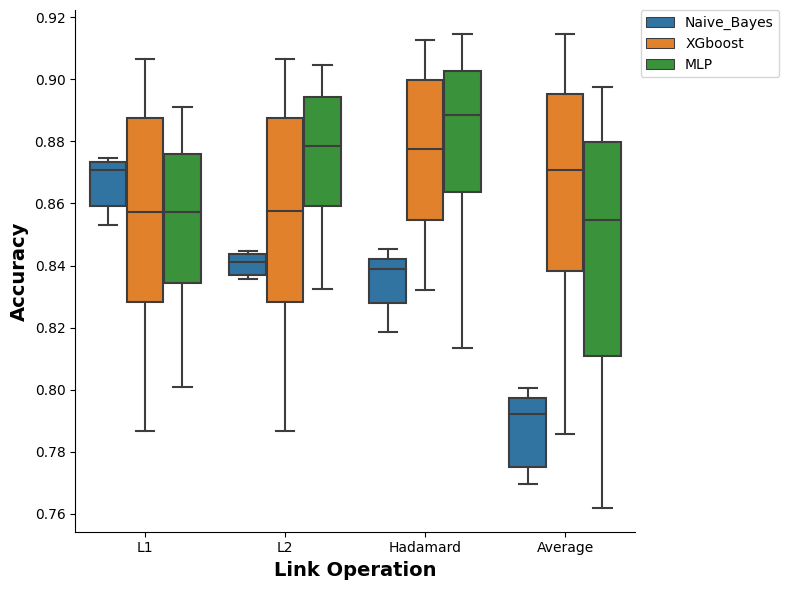

In [14]:
final_results_filter_df.columns = ['Model', 'AUCPR', 'AUC', 'Accuracy', 'link_predcition', 'dilution_factor']

plt.figure(figsize=(8, 6))
sns.boxplot(x='link_predcition', y='Accuracy', hue='Model', data=final_results_filter_df)
#plt.title('Grouped Box Plot: Accuracy by Link Prediction and Model')
plt.xlabel('Link Operation', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy', fontsize=14, fontweight='bold')
sns.despine()
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.savefig('link_prediction_accuracy.new.png', dpi=300)
# Display the plot
plt.show()

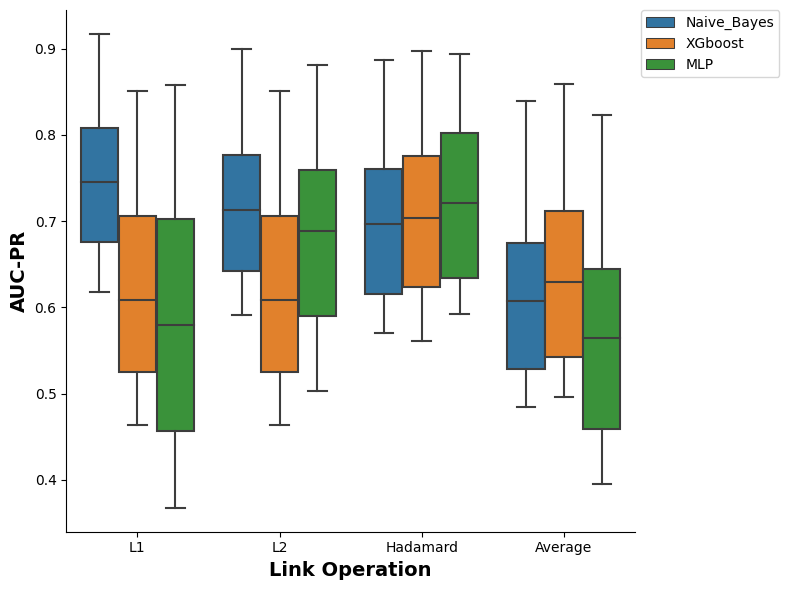

In [15]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='link_predcition', y='AUCPR', hue='Model', data=final_results_filter_df)
#plt.title('Grouped Box Plot: Accuracy by Link Prediction and Model')
plt.xlabel('Link Operation', fontsize=14, fontweight='bold')
plt.ylabel('AUC-PR', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
sns.despine()
plt.tight_layout()
plt.savefig('link_prediction_AUCPR.new.png', dpi=300)
# Display the plot
plt.show()

In [17]:
#final_results_filter_dil_df = final_results_filter_df[final_results_filter_df['dilution_factor']]
final_results_filter_df.groupby(['Model', 'link_predcition'])['AUCPR', 'Accuracy'].mean()

AUCPR  Accuracy
Model       link_predcition                    
MLP         Average          0.573709  0.842415
            Hadamard         0.726928  0.878883
            L1               0.591734  0.852506
            L2               0.684634  0.874507
Naive_Bayes Average          0.622520  0.787170
            Hadamard         0.703830  0.835345
            L1               0.751541  0.866684
            L2               0.720948  0.840517
XGboost     Average          0.644239  0.862919
            Hadamard         0.710549  0.875614
            L1               0.625851  0.854243
            L2               0.625879  0.854235

In [ ]:
final_results_filter_dil_df